In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from glob import glob
import pandas as pd

In [2]:
cv2.__version__

'4.1.2'

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

# Preprocessing

In [4]:
def four_point_transform(image, pts, maxWidth=410, maxHeight=1000):
  """
  Crops out the image from given points and projects them to rect with
  h = maxheight, w = maxWidth
  """
  src = pts

  dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype = "float32")


  # compute the perspective transform matrix and then apply it
  M = cv2.getPerspectiveTransform(src, dst)
  warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
  # return the warped image
  return warped

In [5]:
# Contains the corner points of image 
desc = pd.read_csv('points.csv', header=None)
print(desc.head())
def get_corner_points(imgname):
  row = (desc[desc[0]==imgname]).squeeze()
  # print(row)
  tl = row[1:3].tolist()
  tr = row[3:5].tolist()
  br = row[5:7].tolist()
  bl = row[7:].tolist()
  # print(tl, tr, br, bl)
  corners = np.array([tl, tr, br, bl], dtype = "float32")
  return corners
  

                  0    1    2     3    4     5     6    7     8
0          mega.jpg    0    0  1350    0  1350  3264    0  3264
1  mega_filled1.jpg    0    0  1350    0  1350  3264    0  3264
2  mega_filled2.jpg    0    0  1806    0  1806  4032    0  4032
3  mega_filled3.jpg  740  485  2184  436  2427  4020  615  4030
4  mega_filled4.jpg  859  897  2081  871  2235  3937  763  3901


In [6]:
fn = glob("mega*")
fn = sorted(fn)
for n in fn:
  print(f"Processing file {n}")
  pts = get_corner_points(n)
  print(pts)

Processing file mega.jpg
[[   0.    0.]
 [1350.    0.]
 [1350. 3264.]
 [   0. 3264.]]
Processing file mega_filled1.jpg
[[   0.    0.]
 [1350.    0.]
 [1350. 3264.]
 [   0. 3264.]]
Processing file mega_filled2.jpg
[[   0.    0.]
 [1806.    0.]
 [1806. 4032.]
 [   0. 4032.]]
Processing file mega_filled3.jpg
[[ 740.  485.]
 [2184.  436.]
 [2427. 4020.]
 [ 615. 4030.]]
Processing file mega_filled4.jpg
[[ 859.  897.]
 [2081.  871.]
 [2235. 3937.]
 [ 763. 3901.]]
Processing file mega_filled5.jpg
[[ 773.  973.]
 [1987.  955.]
 [2097. 3921.]
 [ 701. 3939.]]
Processing file mega_filled6.jpg
[[ 669.  649.]
 [2061.  657.]
 [2125. 4032.]
 [ 457. 3993.]]
Processing file mega_filled7.jpg
[[ 625.  249.]
 [2169.  233.]
 [2345. 4032.]
 [ 443. 3993.]]


(1000, 410, 3)


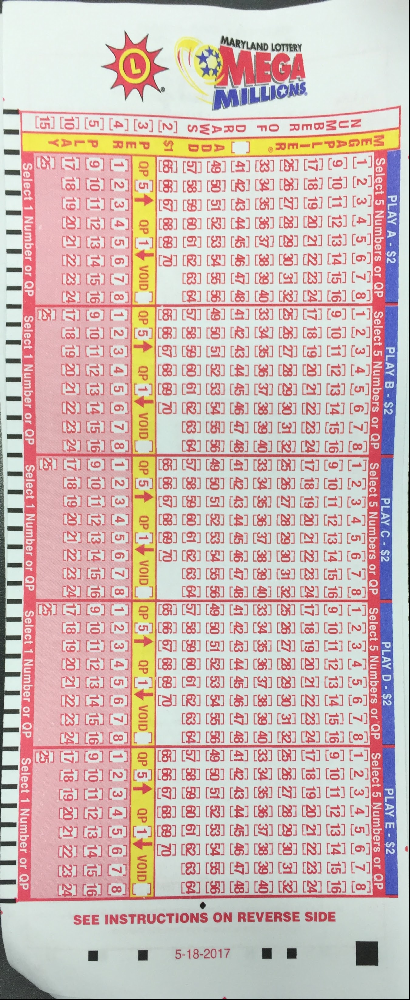

In [7]:
fname = "mega.jpg"
img = cv2.imread(fname) 
# img = cv2.resize(img, (410, 1000))
pts = get_corner_points(fname)
img = four_point_transform(img, pts)
print(img.shape)
cv2_imshow(img)

# Background Removal

In [8]:
_img = img.copy()
_img[:,:,:2] = 0 # set B and G channels to zero

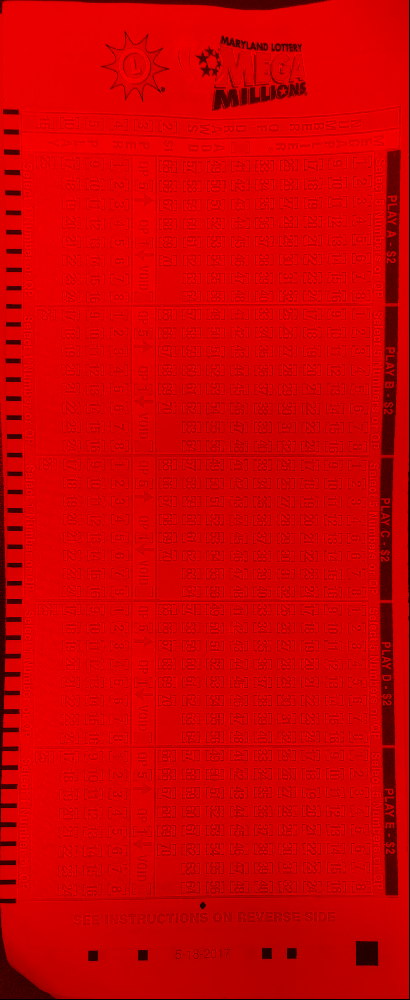

In [9]:
cv2_imshow(_img)

Result


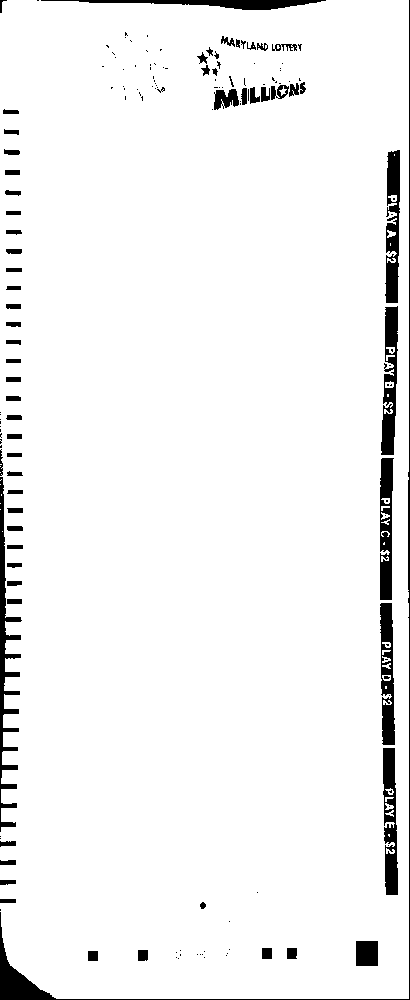

In [10]:
_imgr = _img[:,:,2].copy() #extract just the R channel
# perform threshold
_imgr[_imgr > 128] = 255
_imgr[_imgr <= 128] = 0
print("Result")
cv2_imshow(_imgr)

Result


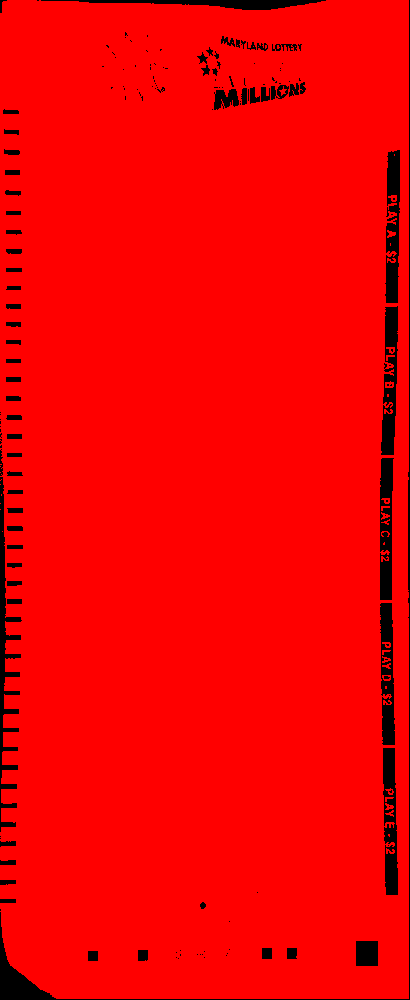

In [11]:
thres = _img.copy()
thres[:,:,2] = _imgr

print("Result")
cv2_imshow(thres)

In [12]:
def pre_process(fname, img):
  _img = img.copy()
  pts = get_corner_points(fname)
  _img = four_point_transform(_img, pts)
  return _img

def get_mask(img, preview=True):
  _img = img.copy()
  _img[:,:,:2] = 0
  _imgr = _img[:,:,2].copy()
  _imgr[_imgr > 128] = 255
  _imgr[_imgr <= 128] = 0

  if(preview):
    print("Mask")
    cv2_imshow(_imgr)
  return _imgr

Mask


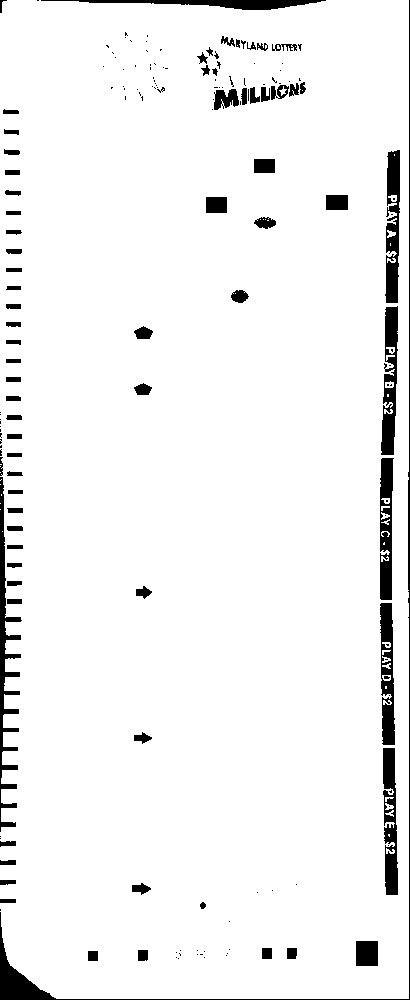

In [13]:
fname = "mega_filled1.jpg"
test_img = cv2.imread(fname)
test_img = pre_process(fname, test_img)
test_mask = get_mask(test_img)

## Removing surrounding area
The black pixels like those in the lower left corner or towards the edges are not part of the foreground. So, we explore the ways to remove them here.

Contour plot


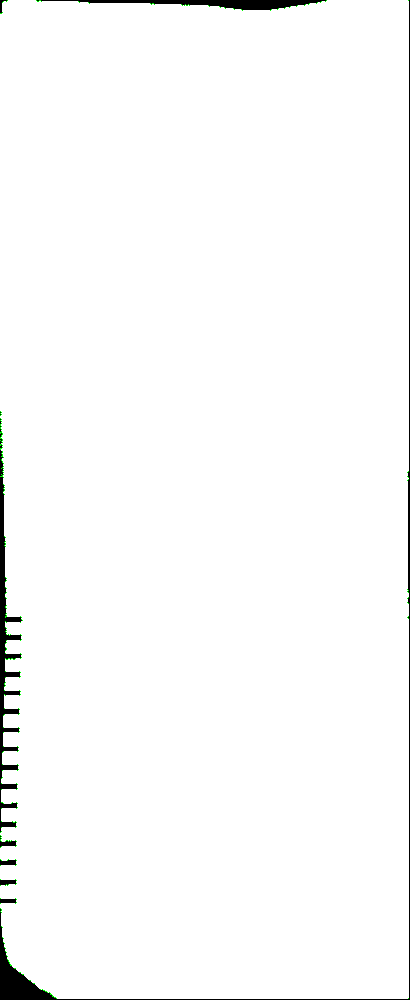

Displaying hull


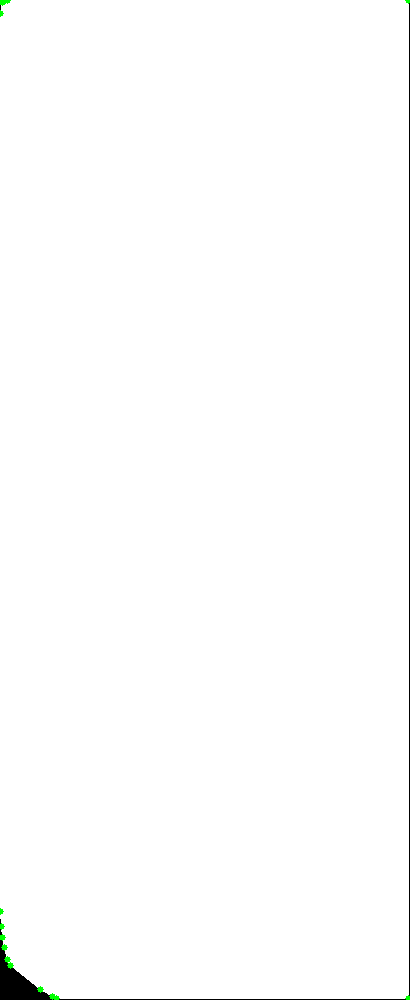

Arc length approximation


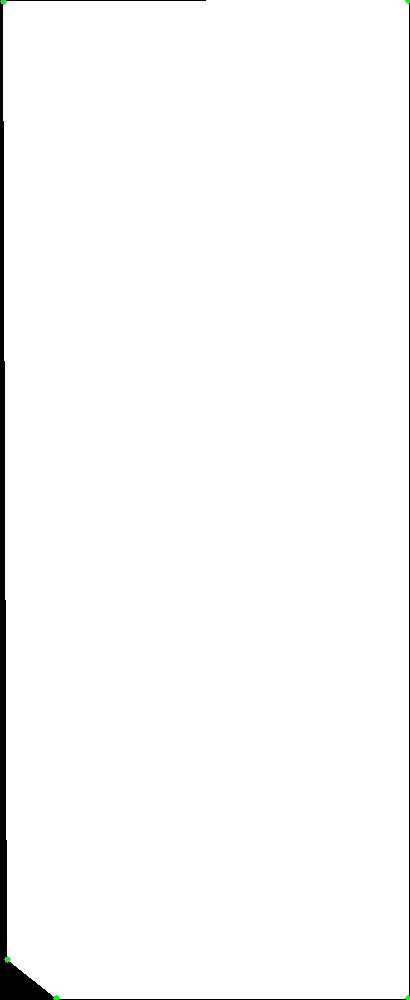

In [14]:

#1. Using Contours
contours, hierarchy = cv2.findContours(_imgr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# create an empty black image
thresh = _imgr.copy()

longest_contour = []
for c in contours:
  longest_contour = c if len(c) > len(longest_contour) else longest_contour
contourfill = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8) 
cv2.fillPoly(contourfill, pts =[longest_contour], color=(255,255,255))
print("Contour plot")
cv2_imshow(cv2.drawContours(contourfill, longest_contour, -1, (0,255,0), 1))

cnt = longest_contour

# 2. Convex Hull
hull = cv2.convexHull(cnt)
hullfill = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)
cv2.fillPoly(hullfill, pts =[hull], color=(255,255,255))
print("Displaying hull")
cv2_imshow(cv2.drawContours(hullfill, hull, -1, (0,255,0), 5))

#3. Arc approximation
print("Arc length approximation")
epsilon = .005*cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt,epsilon,True)
approxfill = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)
cv2.fillPoly(approxfill, pts =[approx], color=(255,255,255))
cv2_imshow(cv2.drawContours(approxfill, approx, -1, (0,255,0), 5))


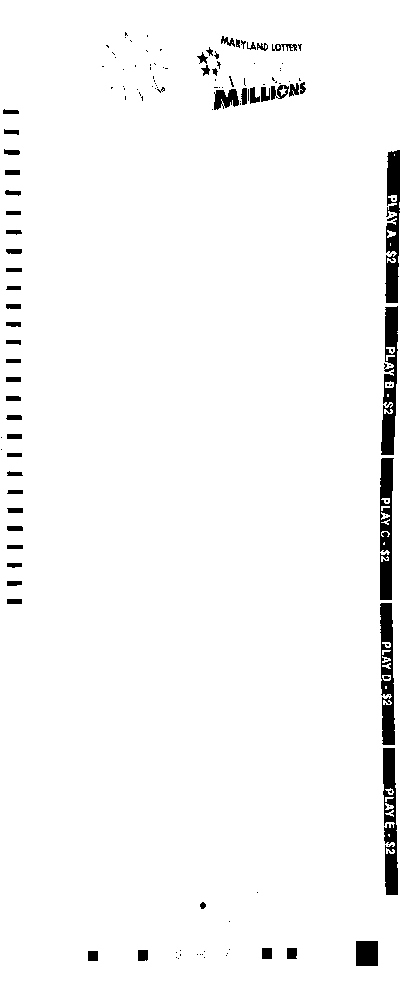

In [15]:
filter = _imgr.copy()
filter[contourfill[:, :, 0] == 0] = 255
cv2_imshow(filter)

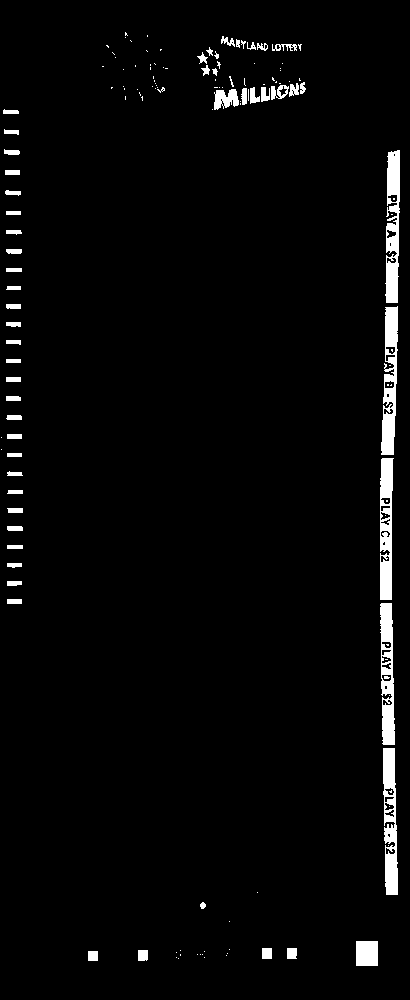

In [16]:
inv = (np.invert(filter))
cv2_imshow(inv)

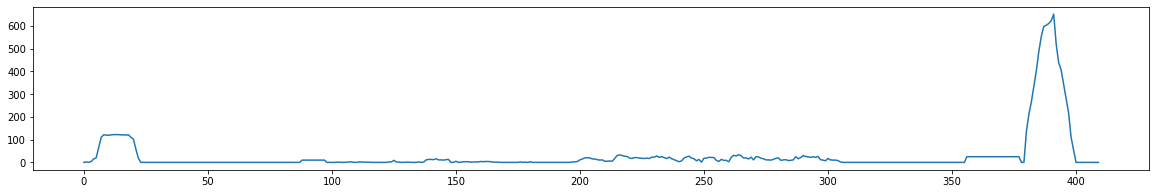

In [17]:
sum_x = np.sum(inv / 255, axis=0)
plt.plot(sum_x)

# Play Segmentation

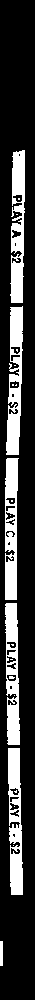

In [18]:
#Crop plays
h, w = inv.shape[:2]
cv2_imshow(inv[:,-35:])

Result of sum over axis=1


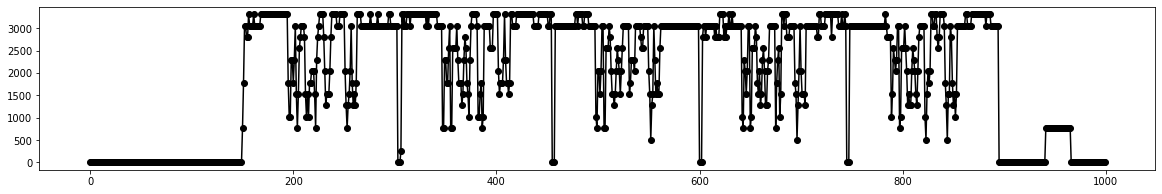

After smoothing


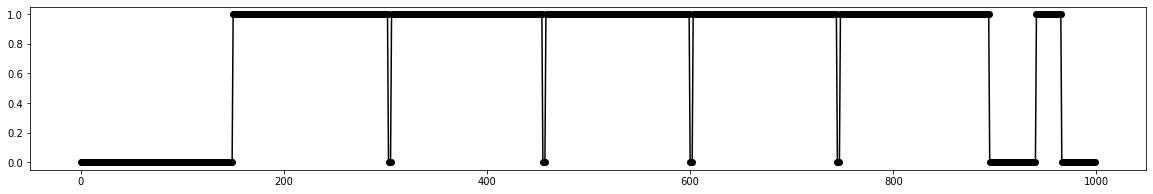

In [19]:
# sum over rows
roi = inv[:,-35:]
rs = np.sum(roi, axis=1)
print("Result of sum over axis=1")
plt.plot(rs, "o-k")
plt.show()

# perform thresholding for smoothing
print("After smoothing")
rs[rs <= 10] = 0
rs[rs > 10] = 1
plt.plot(rs, "o-k")
plt.show()

Difference of t and t+1


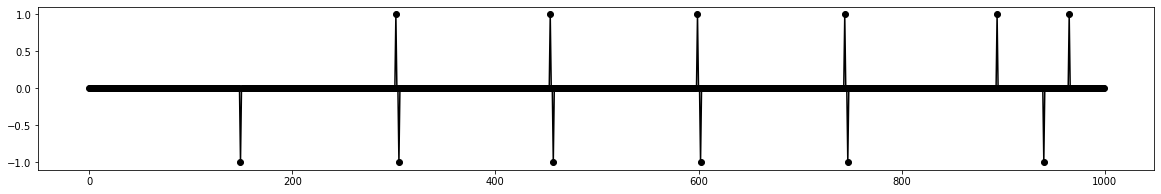

In [20]:
# Find the range of pixels with plays
rsm = np.zeros(rs.shape)
rsm[:-1] = rs[1:]
drs = rs - rsm
print("Difference of t and t+1")
plt.plot(drs, "o-k")
plt.show()

In [21]:
# The range for a play is from the -ve dip to the +ve peak
idxs = np.argwhere(drs != 0 )
idxs =  np.reshape(idxs, (-1, 2))
print(idxs)

[[149 302]
 [305 454]
 [457 599]
 [602 744]
 [747 894]
 [940 965]]


segment {start}


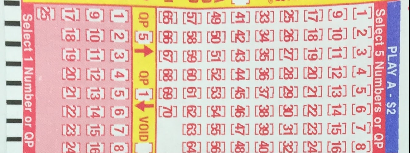

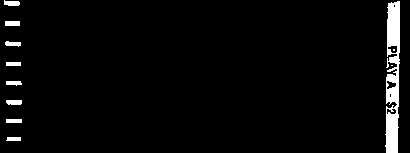

segment {start}


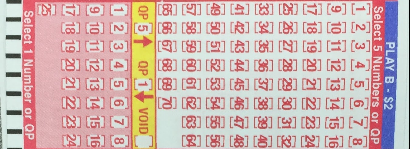

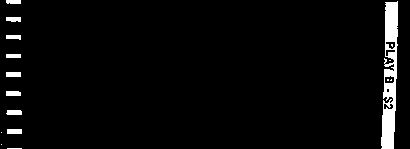

In [22]:
#Result
for i in range(2):
  start, end = idxs[i]
  print("segment {start}")
  cv2_imshow(img[start:end])
  cv2_imshow(inv[start:end])

# Inference

Segment


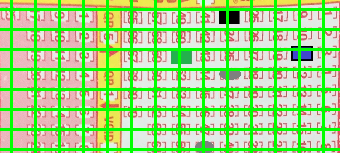

Segment


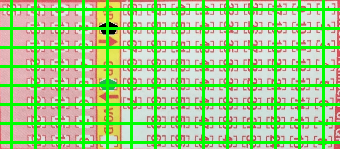

Segment


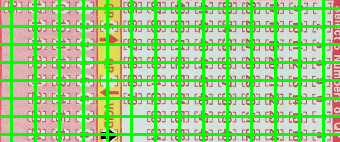

Segment


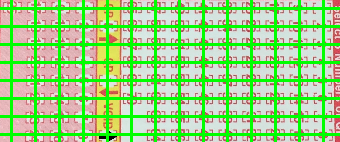

In [23]:
# Approximate grid
for i in range(4):
  start, end = idxs[i]
  _seg = test_img[start:end].copy()

  ls = int(_seg.shape[0] / 8)

  ln = int(ls / 2)
  while ln < _seg.shape[0]:
    cv2.line(_seg, (0, ln), (_seg.shape[1], ln), (0,255,0), 2)
    ln += ls+1
  print("Segment")
  # cv2_imshow(_seg)
  
  _seg = _seg[:,35:-35]
  ls = int(_seg.shape[1] / 15)
  ln = int(ls / 2) 
  while ln < _seg.shape[1]:
    cv2.line(_seg, (ln, 0), (ln, _seg.shape[0]), (0,255,0), 2)
    ln += ls + 2
  cv2_imshow(_seg)

In [24]:
def pre_process(fname, img):
  _img = img.copy()
  pts = get_corner_points(fname)
  _img = four_point_transform(_img, pts)
  return _img

def get_mask(img, preview=False):
  # Thresholding for background removal
  _img = img.copy()
  _img[:,:,:2] = 0
  _imgr = _img[:,:,2].copy()
  _imgr[_imgr > 128] = 255
  _imgr[_imgr <= 128] = 0

  # Clean up unwanted pixels in background
  contours, hierarchy = cv2.findContours(_imgr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  thresh = _imgr.copy()

  longest_contour = []
  for c in contours:
    longest_contour = c if len(c) > len(longest_contour) else longest_contour
  contourfill = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8) 
  cv2.fillPoly(contourfill, pts =[longest_contour], color=(255,255,255))

  bg = _imgr.copy()
  bg[contourfill[:, :, 0] == 0] = 255 # set region outside of contour as background
  fg = (np.invert(bg)) # compute foreground 

  if(preview):
    print("Mask")
    cv2_imshow(fg)
  return fg

def get_plays(mask, preview=False):
  roi = mask[:,-35:]
  rs = np.sum(roi, axis=1)
  if preview:
    plt.plot(rs, "o-k")
    plt.show()
    
  rs[rs <= 10] = 0
  rs[rs > 10] = 1
  if preview:
    plt.plot(rs, "o-k")
    plt.show()

  rsm = np.zeros(rs.shape)
  rsm[:-1] = rs[1:]
  drs = rs - rsm
  if preview:
    plt.plot(drs, "o-k")
    plt.show()

  idxs = np.argwhere(drs != 0 )
  idxs =  np.reshape(idxs, (-1, 2))
  return idxs

def process_plays(img, idx):
  pass

Processing file mega_filled2.jpg
Mask


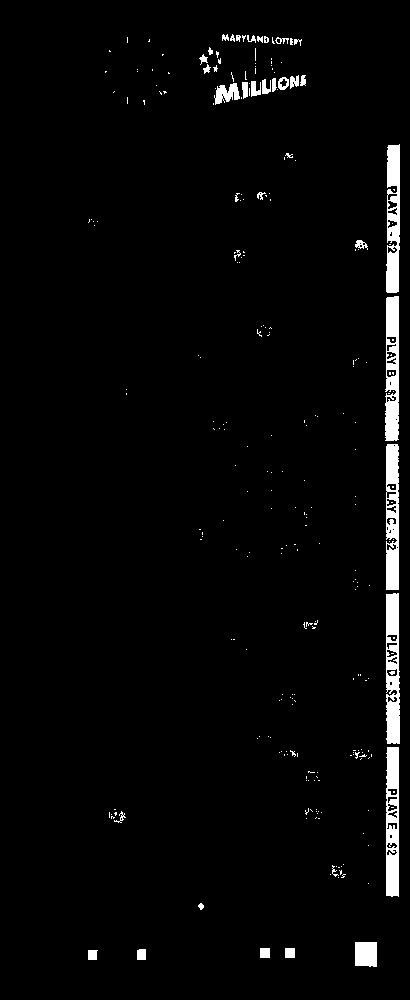

Processing file mega_filled3.jpg
Mask


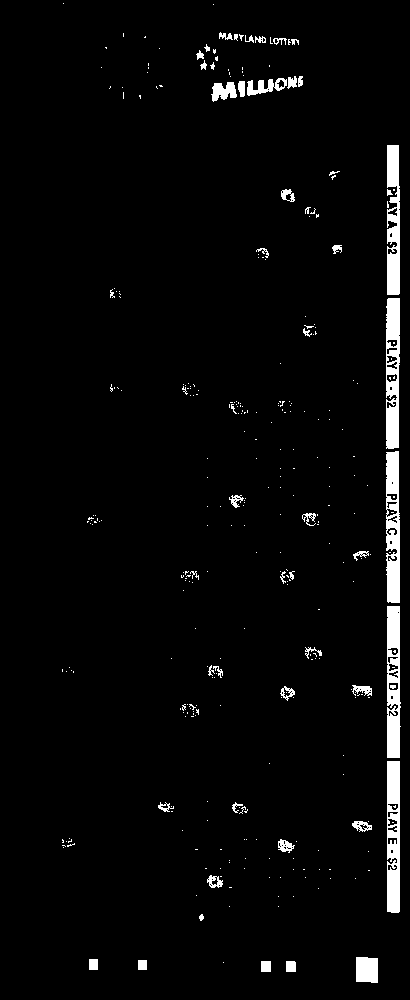

Processing file mega_filled5.jpg
Mask


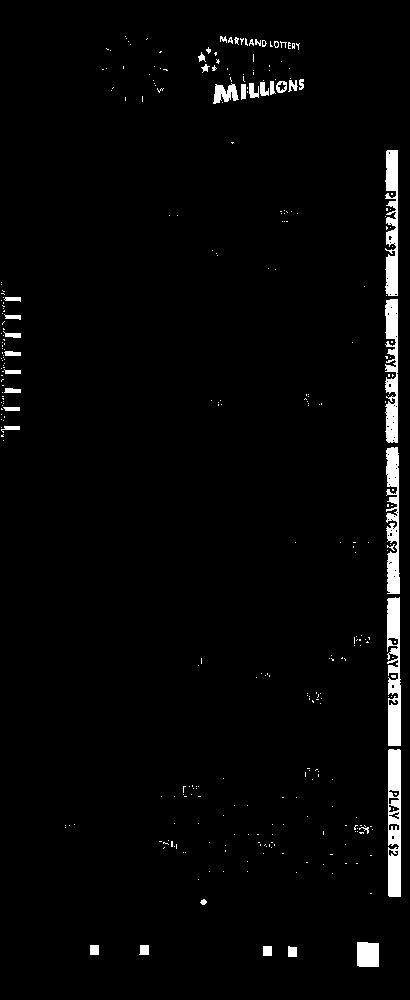

Processing file mega_filled4.jpg
Mask


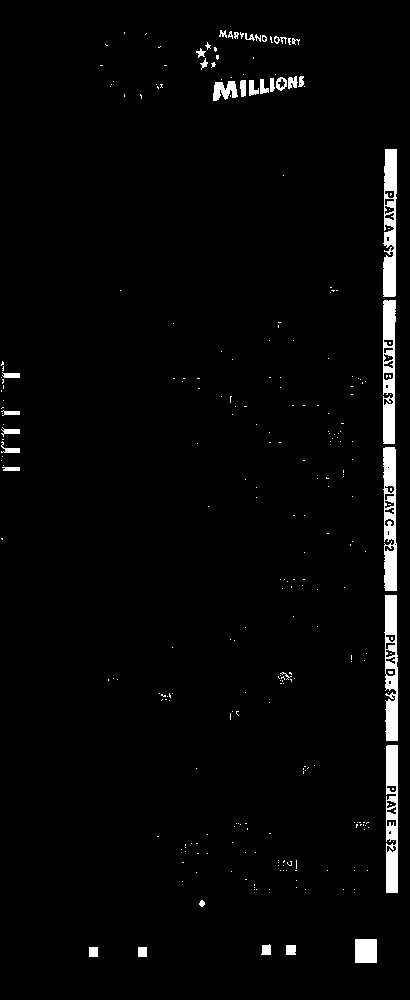

Processing file mega_filled6.jpg
Mask


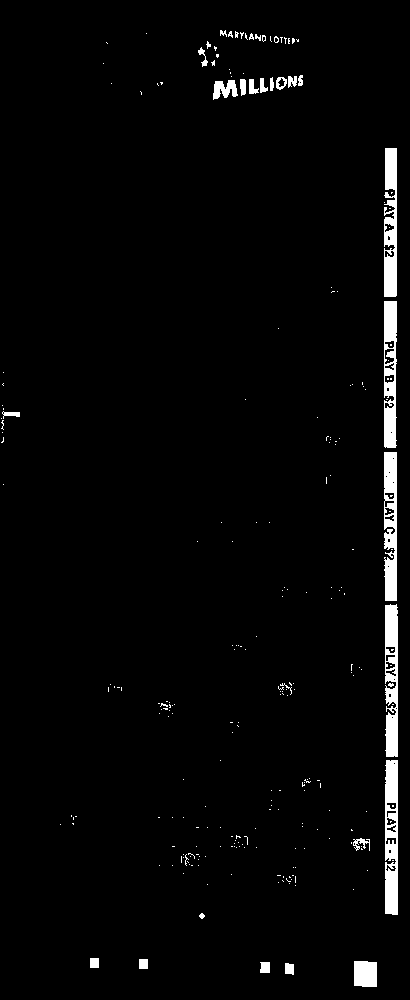

Processing file mega_filled7.jpg
Mask


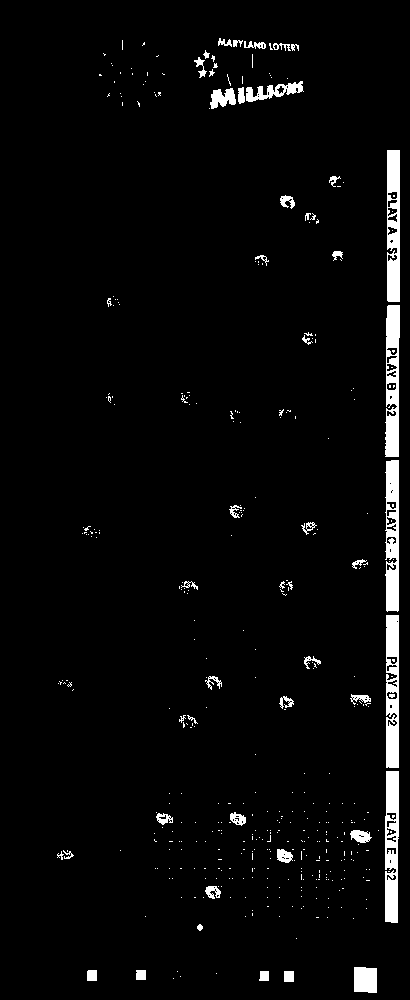

Processing file mega_filled1.jpg
Mask


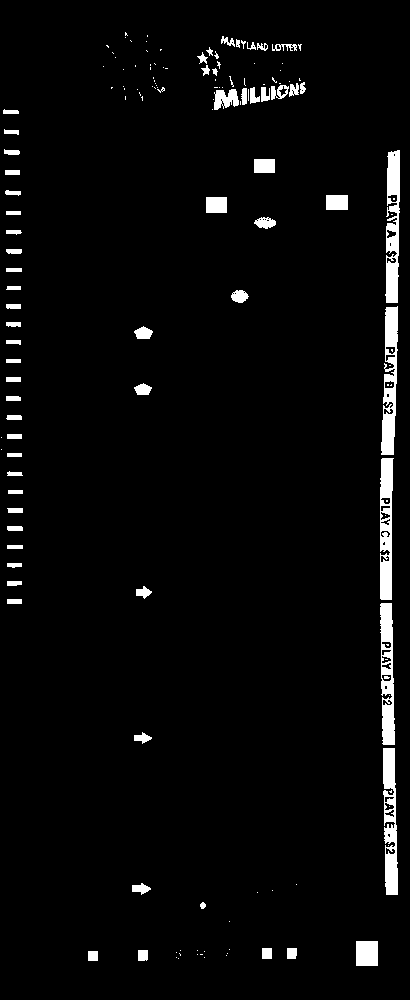

In [25]:
fn = glob("mega_filled*")
for n in fn:
  print(f"Processing file {n}")
  img = cv2.imread(n)
  img = pre_process(n, img)
  mask = get_mask(img, True)
  plays = get_plays(mask, False)

  continue
  for i in range(len(plays)):
    print("processing play: " + str(plays[i]))
    process_plays(img, plays[i])

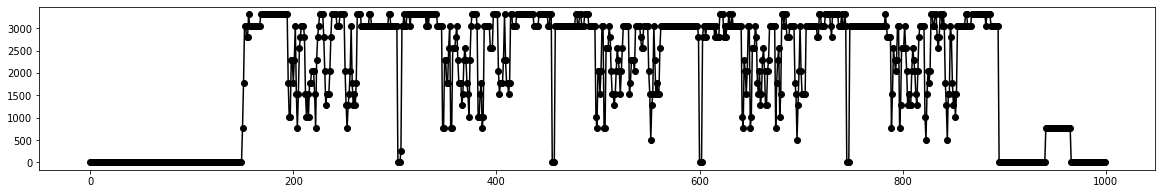

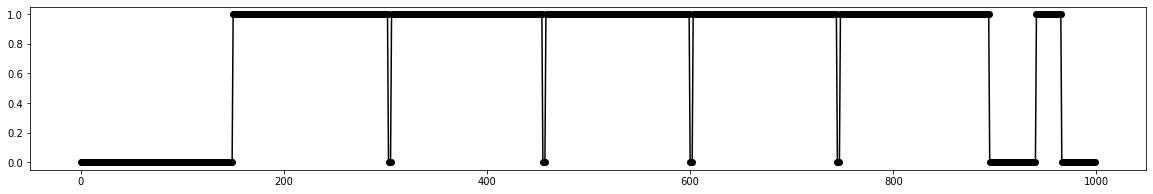

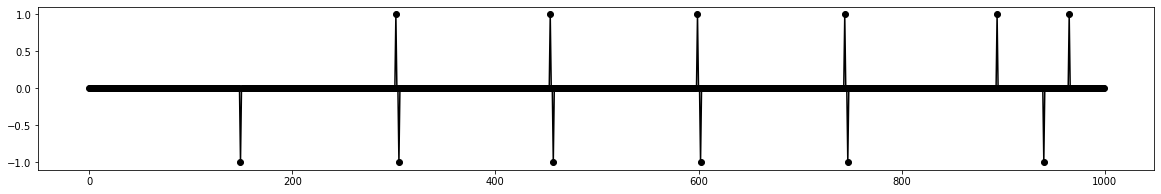

In [26]:
fname = "mega_filled1.jpg"
test_img = cv2.imread("mega_filled1.jpg")
test_img = pre_process(fname, test_img)
test_mask = get_mask(test_img)
test_plays = get_plays(test_mask, True)

[149 302]
Original R channel


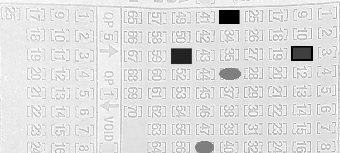

Adaptive threhold: W = 3, c = 0


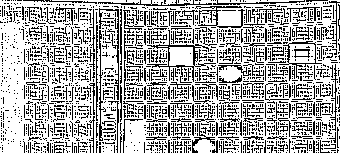

Adaptive threhold: W = 51, c = 0


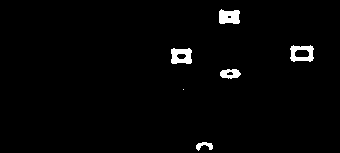

Adaptive threhold: W = 51, c = 17


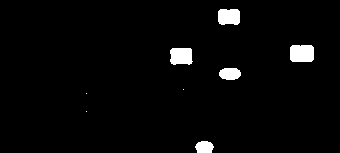

Result of morph transformations


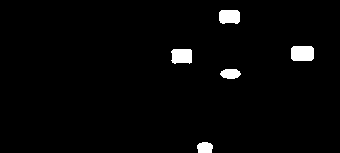

In [27]:
print(test_plays[0])
# roi = test_mask[test_plays[0][0]: test_plays[0][1]].copy()
roi = test_img[test_plays[0][0]: test_plays[0][1]].copy()
roi = roi[:,35:-35,2]
print("Original R channel")
cv2_imshow(roi)

# get better roi estimate
blur = cv2.blur(roi,(5,5))

thres = blur.copy()
thres = cv2.adaptiveThreshold(thres, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 3,0)
print("Adaptive threhold: W = 3, c = 0")
cv2_imshow(thres)

thres = blur.copy()
thres = cv2.adaptiveThreshold(thres, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21,17)
print("Adaptive threhold: W = 51, c = 0")
cv2_imshow(thres)

thres = blur.copy()
thres = cv2.adaptiveThreshold(thres, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,17)
print("Adaptive threhold: W = 51, c = 17")
cv2_imshow(thres)

kernel = np.ones((5,5))
res = thres.copy()
res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel, iterations=1)
res = cv2.erode(res, np.ones((3,2)))

print("Result of morph transformations")
cv2_imshow(res)

total 5
Center: 204, 147
Coords: x 5, y 8
Num: 48
Center: 230, 73
Coords: x 4, y 4
Num: 36
Center: 181, 55
Coords: x 6, y 3
Num: 51
Center: 302, 53
Coords: x 1, y 3
Num: 11
Center: 229, 16
Coords: x 4, y 1
Num: 33
[11, 33, 36, 48, 51]


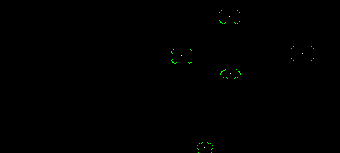

In [28]:
contours, hierarchy = cv2.findContours(res, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contourfill = np.zeros((res.shape[0], res.shape[1], 3), np.uint8) 

filtered_contours = []
print(f"total {len(contours)}")

ls = int(contourfill.shape[1] / 15)
ln = int(ls / 2) 
ls += 2

lsy = int(contourfill.shape[0] / 8)
lny = int(lsy / 2)
lsy+=1
result = []
for c in contours:
  (x, y), (w, h), ang = cv2.minAreaRect(c)
  minSide = min(w,h)
  maxSide = max(w,h)
  if len(c) < 5 or len (c) > 50 or w < 5 or h < 5 or (minSide / maxSide < .25):
    continue
  filtered_contours += [c]
  cv2.drawContours(contourfill, c, -1, (0,255,0), 1)

  # Calculate moments to find center of shaded region
  M = cv2.moments(c)
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])

  print(f"Center: {cx}, {cy}")
  contourfill[cy, cx] = (255,255,255)


  xMod = int(round((x-ln) / ls))
  yMod = int(round((cy - lny) / lsy))

  # Perform reverse of grid approx to find the value
  if xMod >= 5 :
    x = 13 - xMod 
    y = yMod + 1
    print(f"Coords: x {x}, y {y}")
    print(f"Num: {x*8 + y}")
    result += [x*8+y]
print(sorted(result))
cv2_imshow(contourfill)

In [29]:
def pre_process(fname, img):
  _img = img.copy()
  pts = get_corner_points(fname)
  _img = four_point_transform(_img, pts)
  return _img

def get_mask(img, preview=False):
  # Thresholding for background removal
  _img = img.copy()
  _img[:,:,:2] = 0
  _imgr = _img[:,:,2].copy()
  _imgr[_imgr > 128] = 255
  _imgr[_imgr <= 128] = 0

  # Clean up unwanted pixels in background
  contours, hierarchy = cv2.findContours(_imgr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  thresh = _imgr.copy()

  longest_contour = []
  for c in contours:
    longest_contour = c if len(c) > len(longest_contour) else longest_contour
  contourfill = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8) 
  cv2.fillPoly(contourfill, pts =[longest_contour], color=(255,255,255))

  bg = _imgr.copy()
  bg[contourfill[:, :, 0] == 0] = 255 # set region outside of contour as background
  fg = (np.invert(bg)) # compute foreground 

  if(preview):
    print("Mask")
    cv2_imshow(fg)
  return fg

def get_plays(mask, preview=False):
  roi = mask[:,-35:]
  rs = np.sum(roi, axis=1)
  rs[rs <= 10] = 0
  rs[rs > 10] = 1
  if preview:
    plt.plot(rs, "o-k")
    plt.show()

  rsm = np.zeros(rs.shape)
  rsm[:-1] = rs[1:]
  drs = rs - rsm
  if preview:
    plt.plot(drs, "o-k")
    plt.show()

  idxs = np.argwhere(drs != 0 )
  idxs =  np.reshape(idxs, (-1, 2))
  return idxs

def filter_contours(contours, minV=4, maxV=50, minW=5, minH=4, minAspect=.25):
  """
    Filters contours based on passed arguments
    minV = min vertices in contour
    maxV = max vertices in contour
    minW = min width of bounding rect of contour
    minH = min height of bounding rect of contour
    minAspect = min aspect ratio
  """
  filtered_contours = []
  for c in contours:
    (x, y), (w, h), ang = cv2.minAreaRect(c)
    minSide = min(w,h)
    maxSide = max(w,h)
    if len(c) < minV or len(c) > maxV or w < minW or h < minH or (minSide / maxSide < minAspect):
      continue
    filtered_contours += [c]
  return filtered_contours

def get_center(contours):
  # Calculates center based on moments of contour
  centers = [];
  for c in contours:
    M = cv2.moments(c)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    centers += [(cx, cy)]
  return centers

def infer_values(x, y, refW, refH):
  lsx = int(refW / 15)
  lnx = int(lsx / 2) 
  lsx += 2

  lsy = int(refH / 8)
  lny = int(lsy / 2)
  lsy+=1

  xMod = int(round((x-lnx) / lsx)) 
  yMod = int(round((y - lny) / lsy))

  if xMod == 4:
    # coord is one of QP5, QP1 or VOID 
    if yMod <= 2:
      result = (np.random.randint(70, size=5) + 1).tolist()
    elif yMod <= 4:
      result = (np.random.randint(25, size=1) + 1).tolist()
    else:
      return None
  elif xMod > 4:
    # coord is one of the 70 number on right
    x = 13 - xMod 
    y = yMod + 1
    result = [x*8 + y]
  elif xMod < 4:
    # coord is one of 25 power numbers on left
    x = 3 - xMod 
    y = yMod + 1
    result = [x*8 + y]
  
  return result

def better_shaded_roi(img, preview=False):
  roi = img.copy()
  blur = cv2.blur(roi,(5,5))
  
  thres = blur.copy()
  thres = cv2.adaptiveThreshold(thres, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,17)
  
  if preview:
    print(">>>>>>>> Threshold <<<<<<<<<<<")
    cv2_imshow(thres)

  kernel = np.ones((5,5))
  res = thres.copy()
  res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel, iterations=1)
  res = cv2.erode(res, np.ones((3,2)))

  if preview:
    print(">>>>>>>> Closing <<<<<<<<<<<")
    cv2_imshow(res)
  return res

def process_play(img, preview=False):
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  roi = img[:,35:-35,2].copy()
  if preview:
    cv2_imshow(roi)

  # get better roi estimate
  res = better_shaded_roi(roi, preview)

  # find individual shaded region
  contours, hierarchy = cv2.findContours(res, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  filtered_contours = filter_contours(contours)
  if preview:
    contourfill = np.zeros((roi.shape[0], roi.shape[1], 3), np.uint8)
    for c in filtered_contours:
      cv2.drawContours(contourfill, c, -1, (0,255,0), 1)
    print(">>>>>>>> contour <<<<<<<<<<<")
    cv2_imshow(contourfill)
  
  centers = get_center(filtered_contours) #reduce contours to center point

  # determine values of ROIs
  result = []
  for point in centers:
    x, y = point
    value = infer_values(x, y, roi.shape[1], roi.shape[0])
    if value is None:
      return None
    result += value
  return sorted(result)

In [30]:
target = {
	"mega_filled1.jpg": [
		[11, 33, 36, 48, 51],
		["6 Random digits"],
		None,
		None,
		None
	],

	"mega_filled2.jpg": [
		[6, 12, 25, 35, 43, 46],
		[4, 5, 23, 34, 55, 59],
		[8, 20, 20, 30, 34, 46, 61],
		[5, 5, 18, 30, 40, 43, 63],
		[1, 4, 15, 18, 20, 25]
	],

	"mega_filled3.jpg": [
		[8, 10, 14, 20, 27, 38],
		[5, 5, 18, 30, 46, 61],
		[6, 12, 20, 31, 43, 63],
		[5, 19, 20, 29, 52, 62],
		[4, 21, 29, 43, 55, 67]
	],
	"mega_filled4.jpg": [
		[8, 16, 26, 45, 64, 67],
		[5, 13, 16, 26, 46, 61],
		[6, 10 , 16, 24, 25, 32],
		[4, 5, 29, 43, 47, 70],
		[5, 18, 20, 31, 45, 62]
	],
	"mega_filled5.jpg": [
		[8, 8, 28, 39, 54, 68],
		[3, 4, 22, 34, 54, 60],
		[5, 6, 14, 30, 46, 70],
		[3, 12, 12, 22, 37, 60],
		[5, 18, 21, 38, 59, 70]
	],
	"mega_filled6.jpg": [
		[8, 16, 26, 45, 64, 67],
		[5, 13, 16, 26, 46, 61],
		[6, 10, 16, 24, 25, 32],
		[4, 5, 29, 43, 47, 70],
		[5, 18, 20, 31, 45, 62]
	],
	"mega_filled7.jpg": [
		[8, 10, 14, 20, 27, 38],
		[5, 5, 18, 30, 46, 61],
		[6, 12, 20, 31, 43, 63],
		[5, 19, 20, 29, 52, 62],
		[4, 21, 29, 43, 55, 67]
	],

}

In [31]:
fn = glob("mega_filled*")
fn = sorted(fn)
for n in fn:
  print(f"Processing file {n}")
  img = cv2.imread(n)
  img = pre_process(n, img)
  imgr = img[:,:,2].copy()
  mask = get_mask(img)
  plays = get_plays(mask, False)

  for i in range(len(plays)-1):
    print(f"processing play: {i+1}")
    start, end = plays[i]
    result = process_play(img[start:end], False)
    print(f"expected: {target[n][i]}")
    print(f"result  : {result}")

Processing file mega_filled1.jpg
processing play: 1
expected: [11, 33, 36, 48, 51]
result  : [11, 33, 36, 48, 51]
processing play: 2
expected: ['6 Random digits']
result  : [18, 21, 24, 33, 39, 54]
processing play: 3
expected: None
result  : None
processing play: 4
expected: None
result  : None
processing play: 5
expected: None
result  : None
Processing file mega_filled2.jpg
processing play: 1
expected: [6, 12, 25, 35, 43, 46]
result  : [6, 13, 25, 35, 43, 46]
processing play: 2
expected: [4, 5, 23, 34, 55, 59]
result  : [4, 6, 23, 34, 55, 60]
processing play: 3
expected: [8, 20, 20, 30, 34, 46, 61]
result  : [8, 20, 21, 30, 34, 46, 61]
processing play: 4
expected: [5, 5, 18, 30, 40, 43, 63]
result  : [5, 5, 18, 30, 40, 43, 63]
processing play: 5
expected: [1, 4, 15, 18, 20, 25]
result  : [1, 4, 15, 18, 20, 25]
Processing file mega_filled3.jpg
processing play: 1
expected: [8, 10, 14, 20, 27, 38]
result  : [8, 10, 14, 20, 27, 38]
processing play: 2
expected: [5, 5, 18, 30, 46, 61]
resul